# 5 REFORECASTING NOTEBOOK

This notebook takes as input the monthly targets and up to date monthly aggregated dataframes and the outputed models, scalers and dataframes in notebook 2 Retraining. It makes a monthly prediction for both, monthly targets and real values, of the NPS, and compares the associated SHAP values. 

# SET UP

In [2]:
!pip install darts==0.27.0 optuna==3.5.0 shap==0.44.0 miceforest==5.7.0 pandas==2.1.2 xarray==2023.11.0 lightgbm==4.1.0 dask==2023.7.1


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import miceforest as mf

import darts
from darts import TimeSeries
from darts.utils.timeseries_generation import (
    gaussian_timeseries,
    linear_timeseries,
    sine_timeseries,
)

from darts.metrics import mape, smape, mae
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries

from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import RandomForestRegressor

from darts.models import LightGBMModel

from darts.models import LightGBMModel, RandomForest, LinearRegressionModel
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis

from darts.explainability.shap_explainer import ShapExplainer
import pickle
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from darts.models import LinearRegressionModel, LightGBMModel, RandomForest
from calendar import month_name as mn
import os
import seaborn as sns
import numpy as np




import logging

logging.disable(logging.CRITICAL)

import warnings

warnings.filterwarnings("ignore")
import optuna
import shap


In [4]:
shap.initjs()

# GLOBAL VARIABLES

## Parameters

In [5]:
#Month on which the targets were estimated:
targets_estimation_month=11
last_available_month=12

#Year on which the targets were estimated
targets_estimation_year=2023

# Flag to know if the reforecasting is being done on the year where the targets were estimated, or on the year OF the targets.
flag_is_next_year=False 

## Number of available years before the estimated year
num_available_years=2

### Weights for each cabin/haul in current and next year

In [6]:
weight_cabin_haul_targets_estimation_year= {'touchpoints':{
    'Economy_SH_df': 0.701,
    'Economy_LH_df': 0.216,
    'Business_SH_df': 0.050,
    'Business_LH_df': 0.0210,
    'Premium Economy_LH_df': 0.012
},'otp':{
    'Economy_SH_df': 0.88,
    'Economy_LH_df': 0.12,
    'Business_SH_df': 0.88,
    'Business_LH_df': 0.12,
    'Premium Economy_LH_df': 0.12
},
'load_factor' : {
    'Economy_SH_df': 0.701,
    'Economy_LH_df': 0.216,
    'Business_SH_df': 0.050,
    'Business_LH_df': 0.0210,
    'Premium Economy_LH_df': 0.012
}}

In [7]:
weight_cabin_haul_2024= {'touchpoints':{
    'Economy_SH_df': 0.689,
    'Economy_LH_df': 0.230,
    'Business_SH_df': 0.046,
    'Business_LH_df': 0.0230,
    'Premium Economy_LH_df': 0.013
},
'otp':{
    'Economy_SH_df': 0.88,
    'Economy_LH_df': 0.12,
    'Business_SH_df': 0.88,
    'Business_LH_df': 0.12,
    'Premium Economy_LH_df': 0.12
},
'load_factor' : {
    'Economy_SH_df': 0.689,
    'Economy_LH_df': 0.230,
    'Business_SH_df': 0.046,
    'Business_LH_df': 0.0230,
    'Premium Economy_LH_df': 0.013
}}

## Documents from Notebook 3 Targets and notebook 1.b monthly aggregation.

In [8]:
import os

# Get the current working directory
current_directory = os.getcwd()

print("Current Working Directory:", current_directory)

Current Working Directory: /root/NPS forecasting model/nps_model/Production Notebooks/3. Aggregated Model Notebooks


In [9]:
# insert_date_ci='targets_version'
model_version="2023-11-21"
insert_date_ci="2024-01-15"

### Monthly targets

In [10]:
targets_path=f'{current_directory}/inputs_reforecasting/next_year_customer_initiatives_corrected_targets_2024.csv'

### Up-to-date monthly aggregated values

In [11]:
real_values_path = f'{current_directory}/inputs_reforecasting/monthly_NPS_{insert_date_ci}.csv' 

## Models, scalers, dataframes from Notebook 2 Retraining

In [12]:
experiment_dir= f'{current_directory}/OPTUNA_EXP/{model_version}/All_var_all_tp_best_models'

# FUNCTIONS

In [13]:
def create_difference_explanation(explanation2, explanation1):
    """
    Create a new Explanation object representing the difference between two Explanation objects.

    Parameters:
        - explanation1: The first shap.Explanation object.
        - explanation2: The second shap.Explanation object.

    Returns:
        - A new shap.Explanation object representing the difference.
    """
    # Calculate the difference in values, base_values, and data
    diff_values = explanation1.values - explanation2.values
    diff_base_values = explanation1.base_values - explanation2.base_values
    diff_data = explanation1.data - explanation2.data

    # Create a new Explanation object with the difference values
    diff_explanation = shap.Explanation(values=diff_values, base_values=diff_base_values, data=diff_data,
                                        feature_names=explanation1.feature_names)

    return diff_explanation

In [14]:
def create_uplifting_explanation(explanation2, explanation1):
    """
    Create a new Explanation object representing the uplifting between two Explanation objects.

    Parameters:
        - explanation1: The first shap.Explanation object.
        - explanation2: The second shap.Explanation object.

    Returns:
        - A new shap.Explanation object representing the uplifting.
    """
    # Calculate the difference in values, base_values, and data
    diff_values = explanation1.values - explanation2.values
    diff_base_values = explanation2.base_values + sum(explanation2.values)
    diff_data = explanation1.data - explanation2.data

    # Create a new Explanation object with the difference values
    diff_explanation = shap.Explanation(values=diff_values, base_values=diff_base_values, data=diff_data,
                                        feature_names=explanation1.feature_names)

    return diff_explanation

In [15]:
def weighted_shap_addition(explanation_objects, weight_cabin_haul):
    # Initialize aggregated SHAP values with zeros
    aggregated_shap_values = None
    aggregated_base_value = None
    aggregated_data = None
    aggregated_feature_names = []  # To store feature names
    
    # Iterate through each key in the explanation objects
    for key, explanation in explanation_objects.items():
        weighted_shap_values = []
        weighted_base_value = 0  # Initialize as zero for multiplication
        weighted_data = []

        for feature_name in explanation.feature_names:
            # Get the weight based on the feature name
            if feature_name in touchpoint_feature_names:
                weight = weight_cabin_haul['touchpoints'][key]
            elif 'otp' in feature_name:
                weight = weight_cabin_haul['otp'][key]
            elif 'load_factor' in feature_name:
                weight = weight_cabin_haul['load_factor'][key]
            else:
                continue  # Skip if feature name doesn't match any category

            # Multiply SHAP value by the weight
            weighted_shap = explanation[feature_name].values * weight
            weighted_dat = explanation[feature_name].data * weight

            # Accumulate the weighted values
            weighted_shap_values.append(weighted_shap)
            weighted_data.append(weighted_dat)

        # Calculate the weighted base value using the touchpoints weight
        weighted_base_value = explanation.base_values * weight_cabin_haul['touchpoints'][key]

        # Aggregate the weighted SHAP values for the current key
        if aggregated_shap_values is None:
            aggregated_shap_values = np.array(weighted_shap_values)
            aggregated_data = np.array(weighted_data)
            aggregated_base_value = weighted_base_value
        else:
            aggregated_shap_values += np.array(weighted_shap_values)
            aggregated_data += np.array(weighted_data)
            aggregated_base_value += weighted_base_value

        aggregated_feature_names.extend(explanation.feature_names)  # Accumulate feature names

    # Create a new Explanation object with the aggregated values
    aggregated_explanation = shap.Explanation(
        values=aggregated_shap_values,
        base_values=aggregated_base_value,
        data=aggregated_data,
        feature_names=aggregated_feature_names  # Use the accumulated feature names
    )

    return aggregated_explanation

# REFORECAST

## Monthly predictions

### Read the monthly target dataframes

In [16]:
targets_df=pd.read_csv(targets_path)
real_values_df=pd.read_csv(real_values_path)

In [17]:
targets_df[real_values_df['cabin']=='Economy']

,date_flight_local,cabin,haul,bkg_200_journey_preparation_satisfaction,pfl_100_checkin_satisfaction,pfl_200_security_satisfaction,pfl_300_lounge_satisfaction,pfl_500_boarding_satisfaction,ifl_300_cabin_satisfaction,ifl_200_flight_crew_annoucements_satisfaction,...,ifl_100_cabin_crew_satisfaction,arr_100_arrivals_satisfaction,con_100_connections_satisfaction,pun_100_punctuality_satisfaction,loy_200_loyalty_programme_satisfaction,inm_400_issues_response_satisfaction,img_310_ease_contact_phone_satisfaction,load_factor,otp15_takeoff,NPS_weighted
98,2021-03-31,Economy,LH,67.097180,78.332837,87.269903,76.466667,77.558824,69.668580,77.590572,...,73.826471,75.588347,71.946903,84.225698,65.351625,16.547059,57.105076,84.872452,85.868188,27.345390
99,2021-04-30,Economy,LH,63.447328,75.732591,85.130410,76.800000,76.913269,69.554639,76.921235,...,74.071821,77.606007,83.404255,83.057094,63.556021,12.371503,57.362774,87.985514,85.669975,24.530918
100,2021-05-31,Economy,LH,65.628787,75.450529,86.898311,79.611321,79.057337,67.901850,78.266355,...,73.406173,77.436306,80.707071,83.277326,64.357895,11.635849,57.623090,84.158873,86.948956,24.275804
101,2021-06-30,Economy,LH,64.049527,74.073171,88.189512,79.748187,78.797037,70.259737,78.913967,...,74.427441,78.938953,65.900621,81.124307,63.253274,13.380874,56.336059,89.552800,83.119159,21.939912
102,2021-07-31,Economy,LH,62.287003,73.706949,86.146234,78.732039,78.886323,68.330497,79.226392,...,73.153911,76.338353,64.901961,82.860287,64.961468,12.000437,56.600000,90.887811,84.188034,20.916535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,2024-08-31,Global,,71.518350,78.048947,83.027569,75.192407,78.930144,73.898645,81.212289,...,81.278988,79.991640,71.001387,80.938756,66.010784,13.010144,50.937670,86.210925,88.784486,0.000000
284,2024-09-30,Global,,69.680702,77.248074,81.527613,76.691849,75.902753,72.511567,79.997767,...,79.995958,77.694159,67.649103,77.374381,64.882053,11.894759,48.196254,85.371612,87.946190,0.000000
285,2024-10-31,Global,,70.561975,77.641714,82.001815,75.096674,76.517615,72.962163,79.571485,...,80.099973,78.509986,68.693419,78.210058,65.644179,12.839023,51.777388,84.944458,87.862412,0.000000
286,2024-11-30,Global,,71.037536,78.241698,81.016838,75.786020,76.005380,72.224214,78.748212,...,79.575202,78.345092,67.033101,77.246403,65.582236,11.991181,54.217745,84.255091,84.962620,0.000000


#### Helper variables to operate with darts

In [18]:
if flag_is_next_year==True:
    length_updated_NPS=(12-targets_estimation_month + last_available_month)
else:
    length_updated_NPS=(last_available_month - targets_estimation_month) 
    
start_index = num_available_years*12 + targets_estimation_month
end_index = num_available_years*12 + targets_estimation_month + length_updated_NPS

### Group by cabin/haul and filter the model columns

In [19]:
# For real_values_df
real_values_df['date_flight_local'] = pd.to_datetime(real_values_df['date_flight_local'])
# real_values_df = real_values_df[real_values_df['date_flight_local'].dt.year == 2024]

real_values_df.drop(columns=['pun_100_punctuality_satisfaction', 'inm_400_issues_response_satisfaction'], inplace=True)

real_values_grouped = real_values_df.groupby(['cabin', 'haul'])
real_values_grouped_dfs = {}

for group_name, group_data in real_values_grouped:
    cabin_value, haul_value = group_name
    group_df = group_data.copy()
    group_df_name = f'{cabin_value}_{haul_value}_df'
    real_values_grouped_dfs[group_df_name] = group_df

# Clean the covid years in the real_values_df as it was done for the targets
for key in real_values_grouped_dfs.keys():
    df = real_values_grouped_dfs[key]  # Access the DataFrame using the key
    
    df['date_flight_local']=pd.to_datetime(df['date_flight_local'])
    
    df = df[df['date_flight_local'].dt.year.isin([2019, 2022, 2023])]
    
    df['date_flight_local'] = df['date_flight_local'].apply(lambda x: x.replace(year=2021) if x.year == 2019 else x)
    
    df = df.reset_index(drop=True)
    
    real_values_grouped_dfs[key] = df# Replace the grouped DataFrames with the original merged_df DataFrame
    
real_values_df = pd.concat(real_values_grouped_dfs.values())
real_values_df.reset_index(drop=True, inplace=True)

features_1 = {}
for df_id, df in real_values_grouped_dfs.items():
    features_1[df_id] = [col for col in real_values_df.columns if col.endswith('_satisfaction')] + ['load_factor'] + [col for col in real_values_df.columns if col.startswith('otp')] 
    cols_to_keep_1 = ['date_flight_local', 'cabin', 'haul'] + features_1[df_id] + ['NPS_weighted']
    df = df[cols_to_keep_1]
    real_values_grouped_dfs[df_id] = df
    
# For real_values_df
targets_df['date_flight_local'] = pd.to_datetime(targets_df['date_flight_local'])
# real_values_df = real_values_df[real_values_df['date_flight_local'].dt.year == 2024]

targets_df.drop(columns=['pun_100_punctuality_satisfaction', 'inm_400_issues_response_satisfaction'], inplace=True)

targets_grouped = targets_df.groupby(['cabin', 'haul'])
targets_grouped_dfs = {}

for group_name, group_data in targets_grouped:
    cabin_value, haul_value = group_name
    group_df = group_data.copy()
    group_df_name = f'{cabin_value}_{haul_value}_df'
    targets_grouped_dfs[group_df_name] = group_df
    

    
targets_df = pd.concat(targets_grouped_dfs.values())
targets_df.reset_index(drop=True, inplace=True)

features_2 = {}
for df_id, df in targets_grouped_dfs.items():
    features_2[df_id] = [col for col in targets_df.columns if col.endswith('_satisfaction')] + ['load_factor'] + [col for col in targets_df.columns if col.startswith('otp')] 
    cols_to_keep_2 = ['date_flight_local', 'cabin', 'haul'] + features_2[df_id] + ['NPS_weighted']
    df = df[cols_to_keep_2]
    targets_grouped_dfs[df_id] = df

    


### Make predictions and compare them

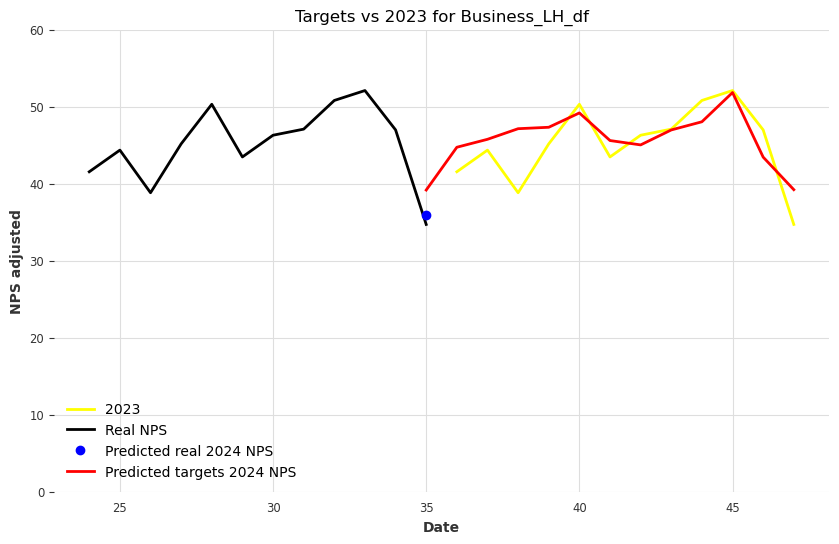

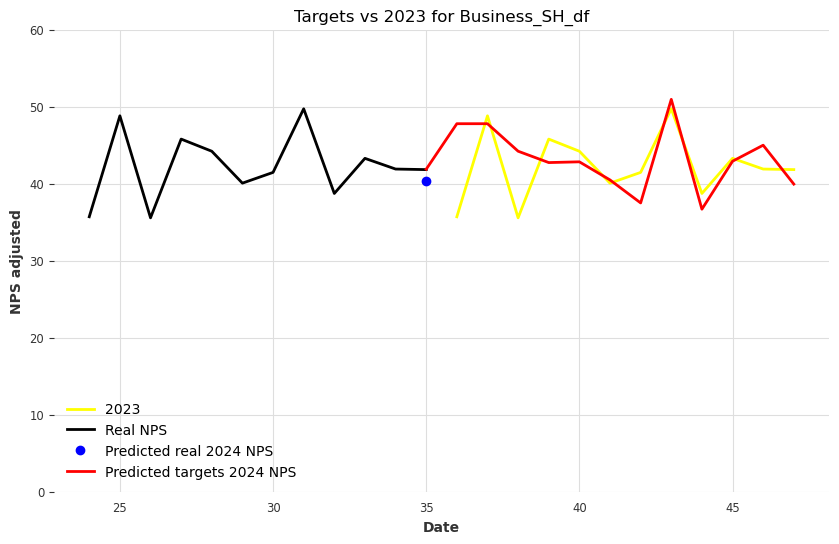

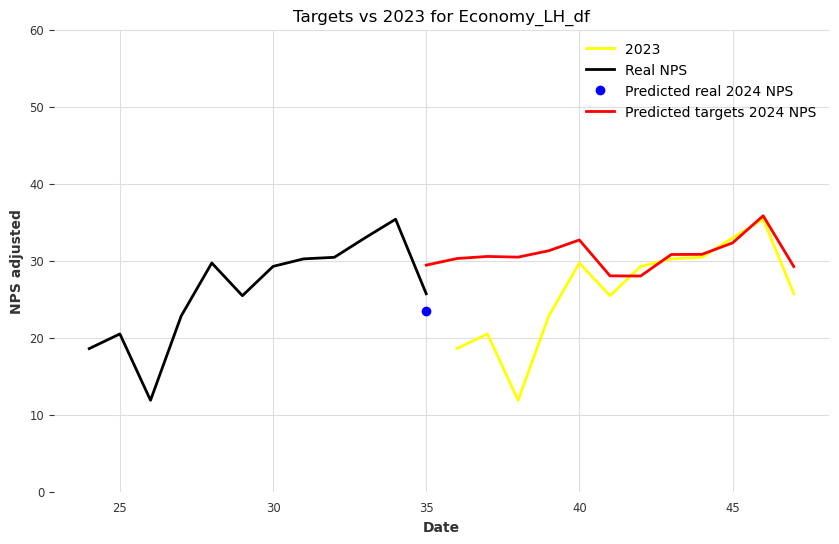

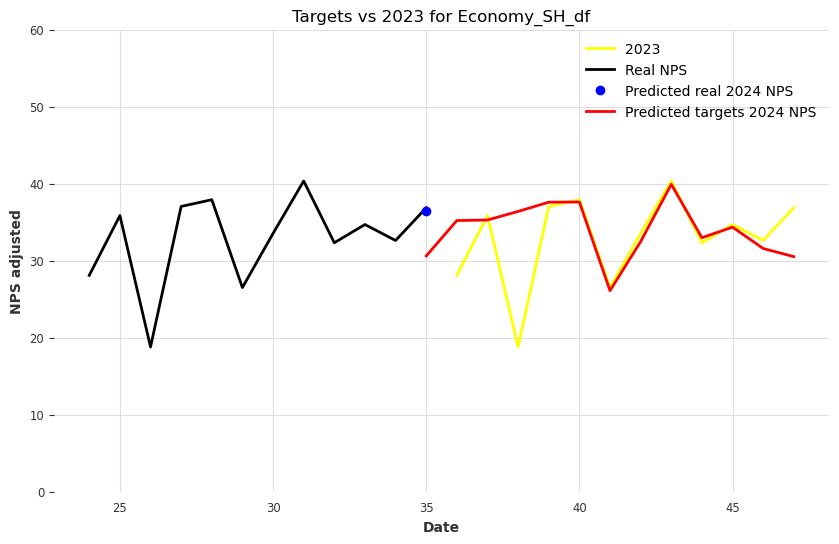

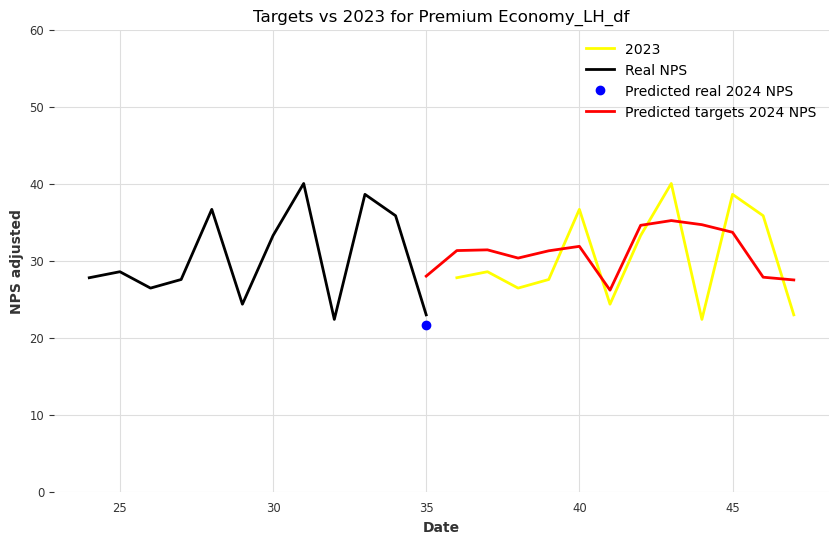

In [20]:
true_mae_agg_model={}
real_values_df={}
targets_df={}
nps_ts={}
real_satisfactions={}
targets_satisfactions={}

real_satisfactions_scaled={}
targets_satisfactions_scaled={}

pred_NPS_real={}
pred_NPS_targets={}

nps_targets_estimation_year={}
nps_last_year={}

best_tuned_models_by_dataframe={}
future_scaler_dict_mae={}
models={}

for key in targets_grouped_dfs.keys(): 
    if key != 'Global_ _df':        
        # Multiple Time series of values ranging from the fist available year to the reforecasting date with the true satisfaction and NPS values.
        real_values_df[key]=real_values_grouped_dfs[key].reset_index(drop=True)
        
        # Multiple Time series ranging from the first available year to the end of the estimated year with the target satisfaction values (no NPS for the months > targets_estimation_month/targets_estimation_year).
        targets_df[key]=targets_grouped_dfs[key].reset_index(drop=True)
        
        # Single time series containing the true NPS available up to date.
        nps_ts[key]= TimeSeries.from_series(real_values_df[key]['NPS_weighted'])
        
        # Single time series containing the nps on the year where the targets were given.
        nps_targets_estimation_year[key]=TimeSeries.from_series(real_values_df[key][(real_values_df[key]['date_flight_local'].dt.year==targets_estimation_year)]['NPS_weighted'].reset_index(drop=True)).shift((num_available_years+1)*12)
        
        
        # Load the pre-trained dataframe
        best_tuned_model_dataframe_path=os.path.join(experiment_dir, f"best_tuned_dataframe_{key}.pkl")
        with open(best_tuned_model_dataframe_path, 'rb') as dataframe_file:
            best_tuned_models_by_dataframe[key] = pickle.load(dataframe_file)
        
        # Load the pre-trained scaler
        future_scaler_path = os.path.join(experiment_dir, f"future_scaler_{key}.pkl")
        with open(future_scaler_path, 'rb') as scaler_file:
            future_scaler_dict_mae[key] = pickle.load(scaler_file)
        
        
        value= best_tuned_models_by_dataframe[key]
        
        
        # Multiple time series with the true satisfactions available up to date.
        real_satisfactions[key] = TimeSeries.from_series(real_values_df[key][features_1[key]])[-(1+length_updated_NPS):]
        future_scaler = future_scaler_dict_mae[key]
        real_satisfactions_scaled[key] = future_scaler.transform(real_satisfactions[key])
        
        # Multiple time series with the target satisfactions (for the full estiamted year).       
        targets_satisfactions[key] = TimeSeries.from_series(targets_df[key][features_2[key]])[-(1+24-targets_estimation_month):]                
        future_scaler = future_scaler_dict_mae[key]
        targets_satisfactions_scaled[key] = future_scaler.transform(targets_satisfactions[key])        

        # Load the pre-trained model
        model_file_path = os.path.join(experiment_dir, f"best_tuned_mae_model_{key}_{value['model_name']}.pkl")
        with open(model_file_path, 'rb') as model_file:
            models[key] = pickle.load(model_file)
        
        # NPS Prediction for real satisfaction values:
        pred_NPS_real[key] = models[key].predict(n=length_updated_NPS, series=nps_ts[key][:-(length_updated_NPS)], future_covariates=real_satisfactions_scaled[key])
        pred_NPS_targets[key] = models[key].predict(n=(24 - targets_estimation_month), series=nps_ts[key][:-(length_updated_NPS)], future_covariates=targets_satisfactions_scaled[key])
        
        plt.figure(figsize=(10, 6))
        
        #NPS in a given year (reference)
        nps_targets_estimation_year[key].plot(label='2023', color='yellow')
        
        # NPS up to date
        nps_ts[key][num_available_years*12:].plot(label='Real NPS', color='black')
        
        # Predicted NPS up to date
        pred_NPS_real[key].plot(label='Predicted real 2024 NPS', color='blue')       
        
        # Targets NPS
        pred_NPS_targets[key].plot(label='Predicted targets 2024 NPS', color='red')
        
        plt.title(f"Targets vs 2023 for {key}")
        plt.xlabel("Date")
        plt.ylabel("NPS adjusted")
        plt.legend()     
        
        plt.ylim(0, 60)  # Set the y-axis limit from 0 to the maximum value
        #plt.savefig(f"{true_output_dir}/forecast_{key}_estimated_touchpoints.png")
        plt.show()   

## SHAP comparison

Business_LH_df


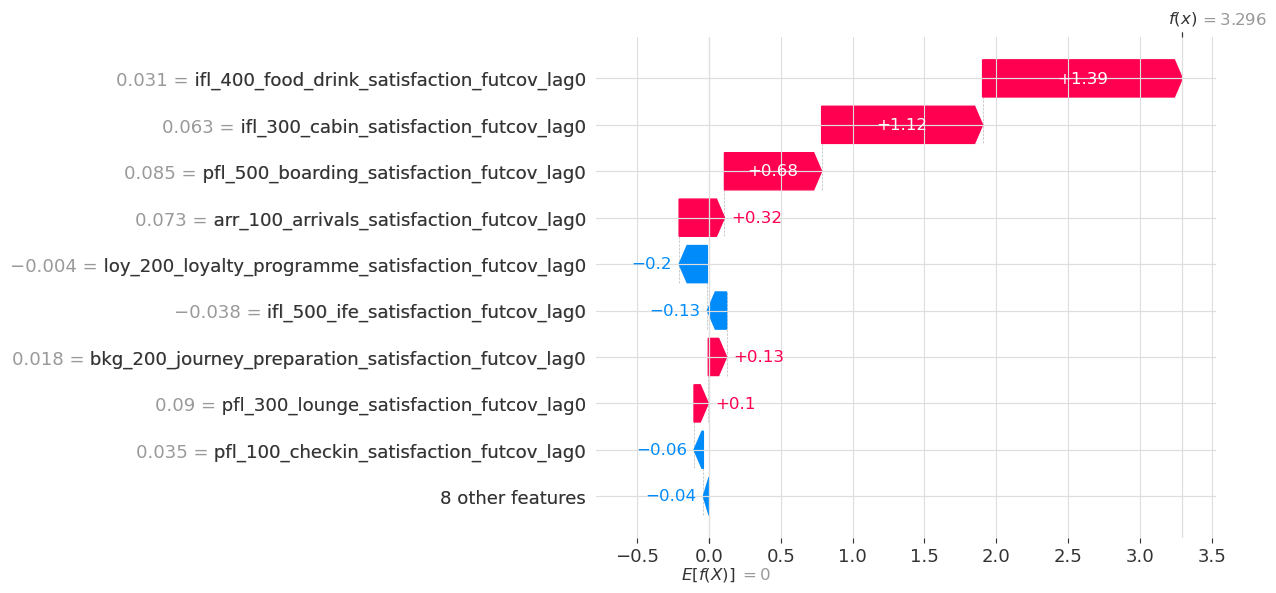

Business_SH_df


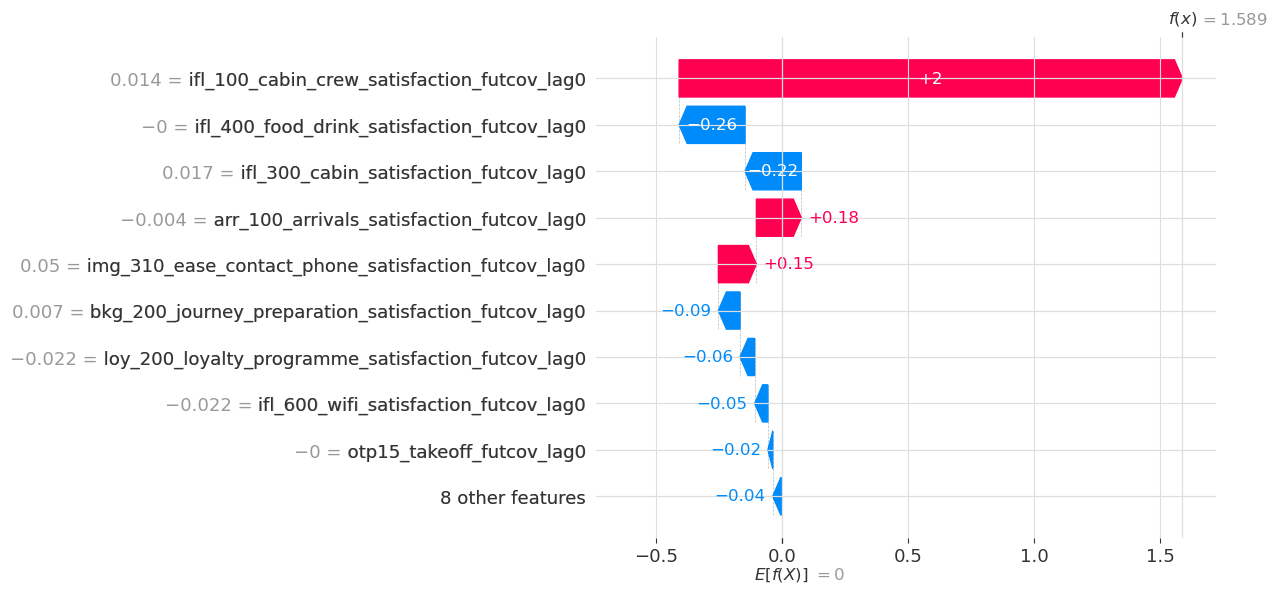

Economy_LH_df


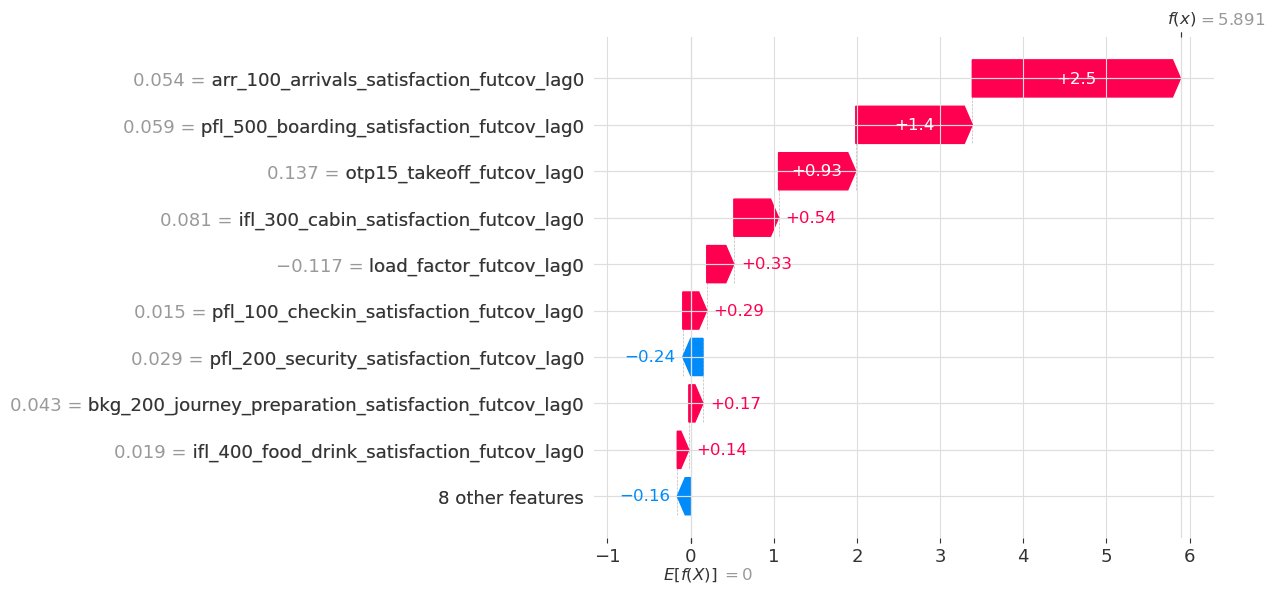

Economy_SH_df


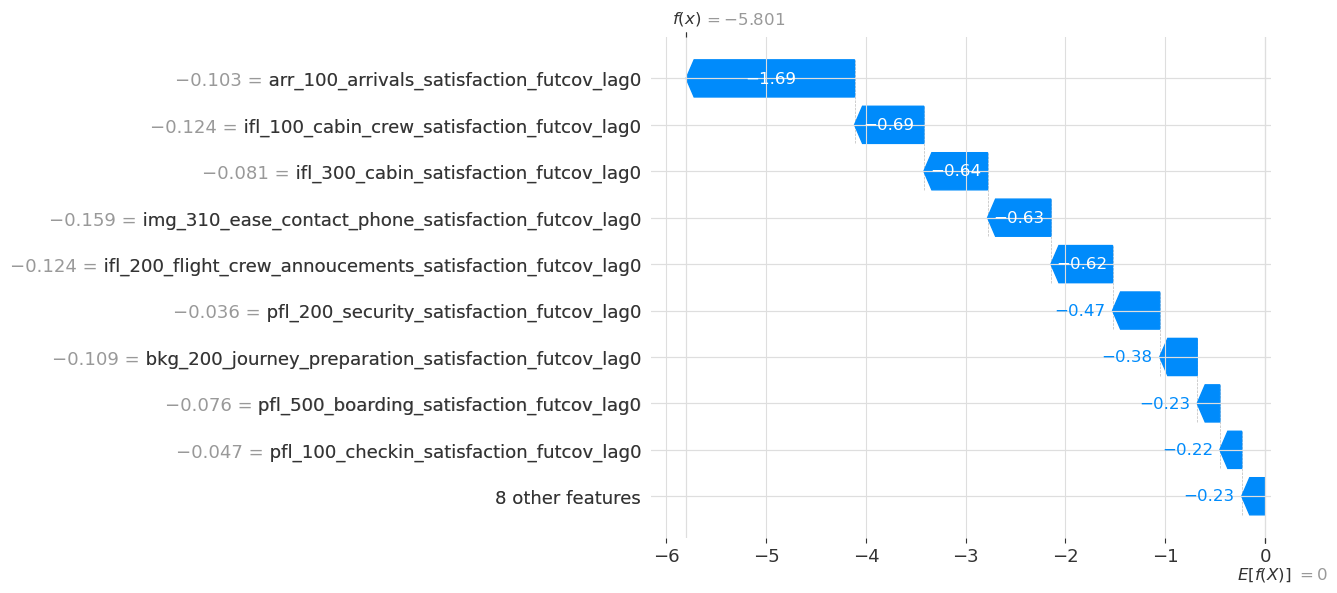

Premium Economy_LH_df


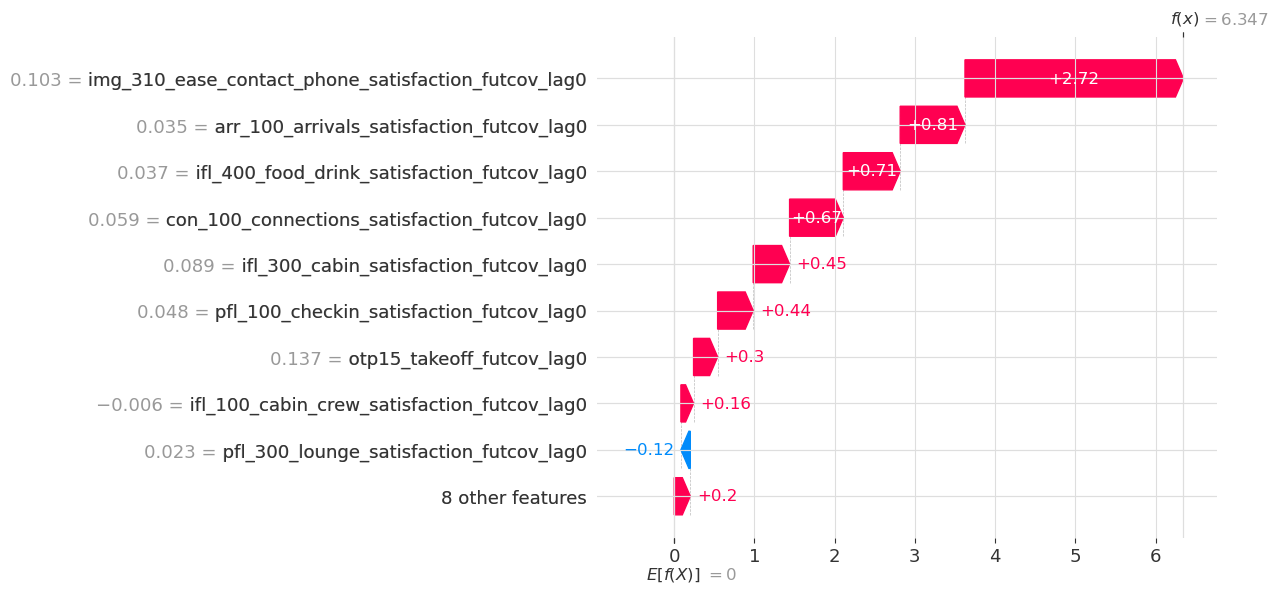

In [25]:
difference_explanations = {}
for key in targets_grouped_dfs.keys(): 
    if key != 'Global_ _df': 
        
        print(key)
        
        #Timeseries to compare
        # SHAPs for each time series        
        shap_explain = ShapExplainer(model=models[key])
        
        real_values_shaps = shap_explain.explain(pred_NPS_real[key], foreground_future_covariates=real_satisfactions_scaled[key][1:])
        real_values_explanation = real_values_shaps.get_shap_explanation_object(horizon=1)
        
        targets_shaps = shap_explain.explain(pred_NPS_targets[key][:length_updated_NPS], foreground_future_covariates=targets_satisfactions_scaled[key][1:1+length_updated_NPS])
        targets_explanation = targets_shaps.get_shap_explanation_object(horizon=1)
        
        difference_explanations[key] = []
        for i in range(length_updated_NPS):
            difference = create_difference_explanation(real_values_explanation[i], targets_explanation[i])
            difference_explanations[key].append(difference)

        
        shap.plots.waterfall(shap_values=difference_explanations[key][0], max_display=10)
        


In [ ]:
        difference_explanations[key]=[]
        for i in range(length_updated_NPS):
            difference_explanations[key][i] = create_difference_explanation(real_values_explanation[i], targets_explanation[i])